# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier

from scripts.auc_curves_data import auc_curves_data
from scripts.auc_curves_plot import auc_curves_plot
from scripts.roc_pr_perceptron import roc_pr_percetron

2021-11-15 00:55:03.047350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 00:55:03.047368: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## LECTURA Y LIMPIEZA DEL DATASET

In [2]:
#datos de entrenamiento (80% del dataset original)
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)  
df_orig.shape

(239, 13)

In [3]:
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, CREATININE_PHOSPHOKINASE, EJECTION_FRACTION, PLATELETS, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT

feat_train, targ_train = df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"]
print(feat_train.shape)
print(targ_train.shape)
# df_cleaned.head()

(239, 6)
(239,)


## Transformaciones necesarias al df

In [4]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)

print(np.sum(targ_train==0))
print(np.sum(targ_train==1))

#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE(random_state=420).fit_resample(feat_train, targ_train)
print(feat_train.shape)

print(np.sum(targ_train==0))
print(np.sum(targ_train==1))

163
76
(326, 6)
163
163


## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [5]:
# Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.
score_metric = "recall" 

---

## ALGUNAS FUNCIONES UTILES PARA GRAFICAR

In [6]:
def train_val_curve (model,param,param_range): 
    train__scores, val__scores = validation_curve(model,feat_train,targ_train,param_name=param,param_range=param_range,scoring=score_metric,cv=20)
    train__mean = np.mean(train__scores,axis=1)
    val__mean = np.mean(val__scores,axis=1)
    
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,2)
    plt.plot(param_range,train__mean,color='blue',marker='o',markersize=5,label='training recall')
    plt.xscale("log")
    plt.plot(param_range,val__mean,color='green',marker='x',markersize=5,label='validation recall') 
    plt.xlabel(param)
    plt.ylabel(score_metric)
    plt.legend(loc='upper left')

In [7]:
def plt_eb (model,rmax):
    means,errors = [],[]
    
    for j in range(2,rmax):
        scorings = cross_val_score(model, feat_train, targ_train,cv=j, scoring=score_metric)
        means.append(scorings.mean())
        errors.append(scorings.std())

    plt.figure(figsize=(12,6))
    plt.xlabel("Cantidad de Folds en CV")
    plt.ylabel("Recall Score")
    plt.title("Mean: {:.3f}+/-{:.3f}".format(np.mean(means),np.mean(errors)))
    plt.ylim((0,1.1))
    plt.errorbar(x=range(2,rmax),y=means,yerr=errors,fmt="-o")

In [8]:
def model_setup (model):
    
    model.fit(feat_train,targ_train)

    scoring = cross_val_score(model, feat_train, targ_train,cv=10, scoring=score_metric)
    print("Cross Validation Score: {:.3f} +/- {:.3f}".format(scoring.mean(),scoring.std()))

    predicted = cross_val_predict(model,feat_train,targ_train,cv=3)
    print(classification_report(targ_train, predicted))
    
    cm = confusion_matrix(targ_train, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()   

---
---
---

# BASELINE

### Perpectron Nº1

Cross Validation Score: 0.542 +/- 0.242
              precision    recall  f1-score   support

           0       0.74      0.57      0.65       163
           1       0.65      0.80      0.72       163

    accuracy                           0.69       326
   macro avg       0.70      0.69      0.68       326
weighted avg       0.70      0.69      0.68       326

[-1.] [[ 0.69317218  3.78883436 -2.64658525  1.55242184  0.82901539 -1.28516939]]


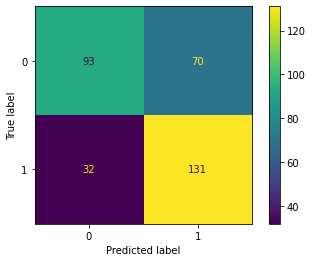

In [9]:
percep1 = Perceptron()  #fit_intercept = True (default)
model_setup(percep1)
print(percep1.intercept_,percep1.coef_)

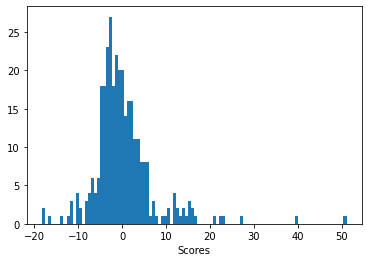

In [10]:
y_scores = cross_val_predict(percep1, feat_train, targ_train, cv=10, method="decision_function")

A = plt.hist(y_scores,100)
plt.xlabel('Scores')
plt.show()

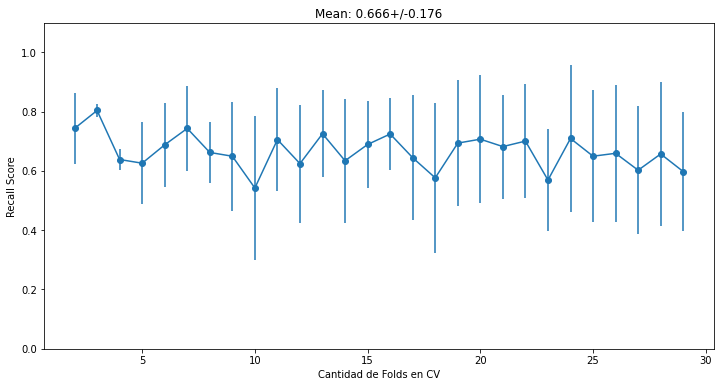

In [11]:
plt_eb(percep1,30)

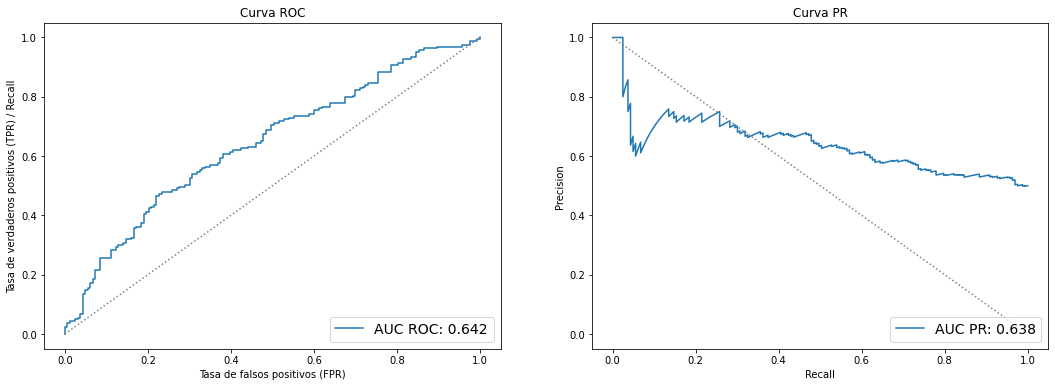

In [12]:
auc_data_percep1 = roc_pr_percetron(targ_train, y_scores,'Percep1')

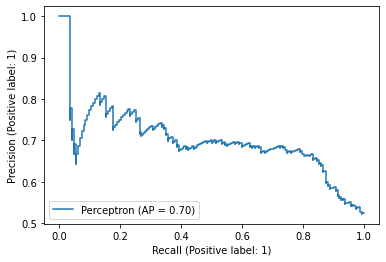

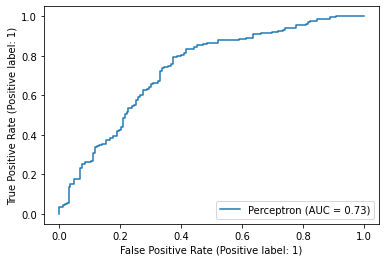

In [13]:
#Genero las mismas curvas pero con otras funciones.
# Observación: dan diferentes, eso es por la selección de cv=10, si coloco cv=5, dan iguales

from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
plot_precision_recall_curve(percep1, feat_train, targ_train)
plot_roc_curve(percep1, feat_train, targ_train)

Cross Validation Score: 0.669 +/- 0.076
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       163
           1       0.68      0.78      0.72       163

    accuracy                           0.70       326
   macro avg       0.71      0.70      0.70       326
weighted avg       0.71      0.70      0.70       326



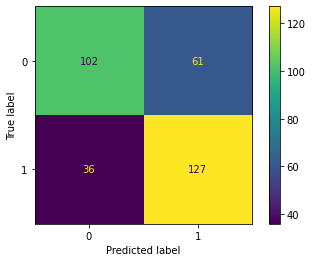

In [14]:
percep2 = Perceptron(max_iter=40000,penalty="l2",random_state=420,alpha=1e-5,eta0=0.05)
model_setup(percep2)

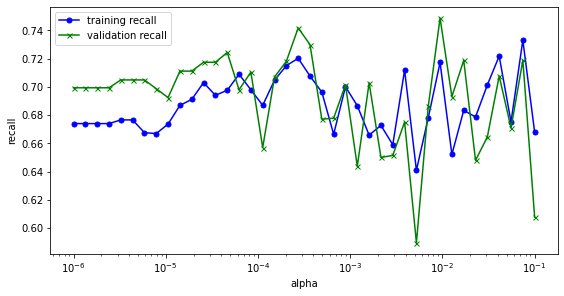

In [15]:
train_val_curve(percep2,"alpha",np.logspace(-6,-1,40))

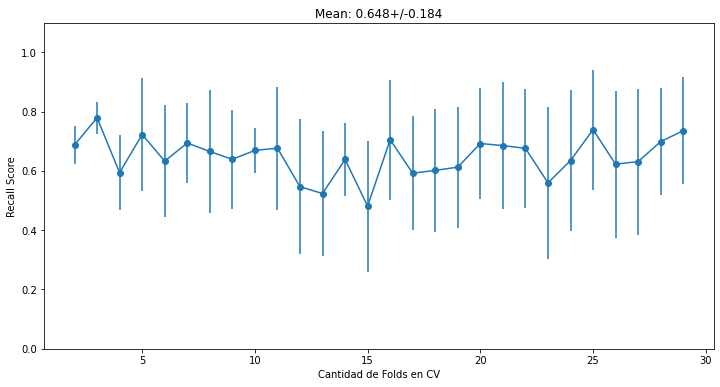

In [16]:
plt_eb(percep2,30)

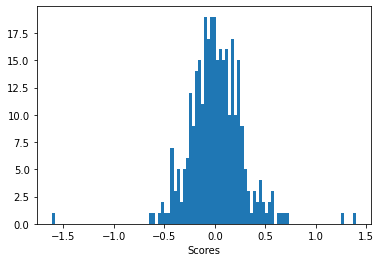

In [17]:
y_scores = cross_val_predict(percep2, feat_train, targ_train, cv=10, method="decision_function")

A = plt.hist(y_scores,100)
plt.xlabel('Scores')
plt.show()

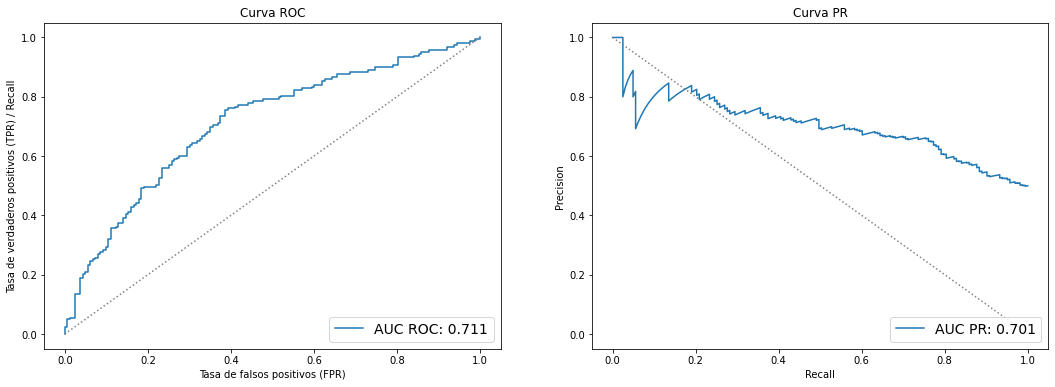

In [18]:
auc_data_percep2 = roc_pr_percetron(targ_train, y_scores,'Percep2')

# LOGISTIC REGRESSION

<!-- ## BEST PARAMS => C=2 -> Recall = 0.811+/-0.066 -->

Cross Validation Score: 0.724 +/- 0.108
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       163
           1       0.72      0.72      0.72       163

    accuracy                           0.72       326
   macro avg       0.72      0.72      0.72       326
weighted avg       0.72      0.72      0.72       326



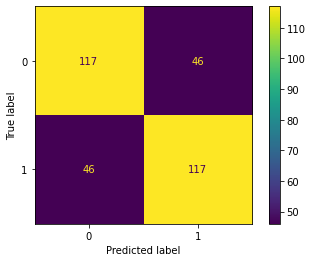

In [19]:
lr_model = LogisticRegression()
model_setup(lr_model)

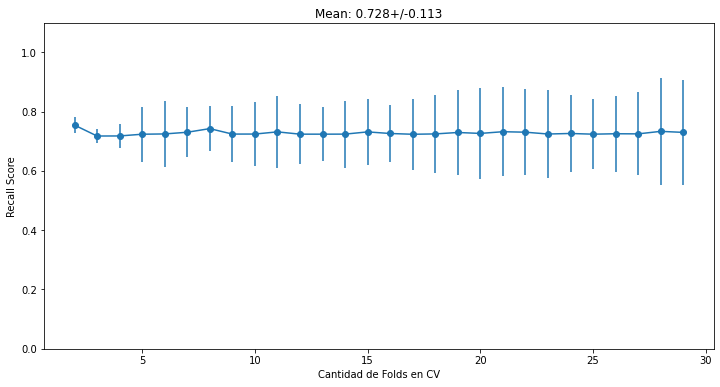

In [20]:
plt_eb(lr_model,30)

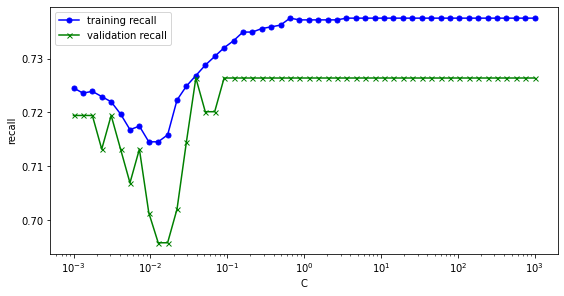

In [21]:
train_val_curve(lr_model,"C",np.logspace(-3,3,50))

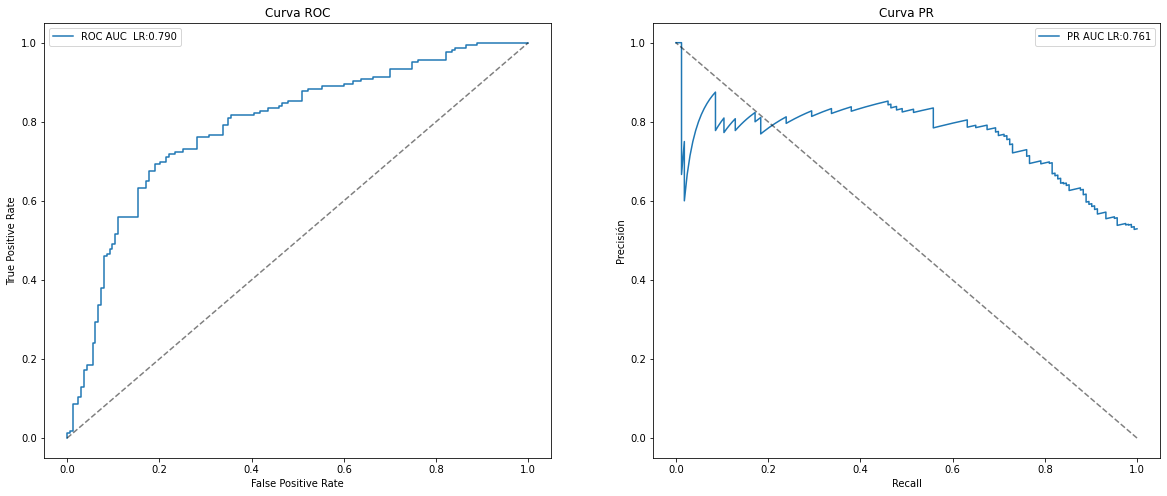

In [22]:
auc_data_lr = []
(ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(lr_model,feat_train,targ_train)
auc_data_lr.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, 'LR'))
auc_curves_plot(auc_data_lr,'LR')

---

# SVC

## BEST PARAMS => C = 0.85, Gamma = 0.61 -> Recall = 0.872+/-0.075

Cross Validation Score: 0.872 +/- 0.075
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       163
           1       0.75      0.85      0.80       163

    accuracy                           0.78       326
   macro avg       0.79      0.78      0.78       326
weighted avg       0.79      0.78      0.78       326



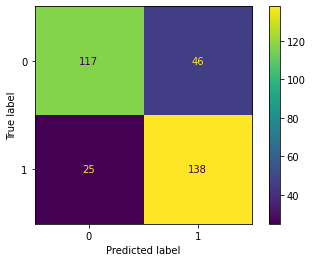

In [23]:
svc_model = SVC(probability=True,gamma=0.61,C=0.85)
model_setup(svc_model)

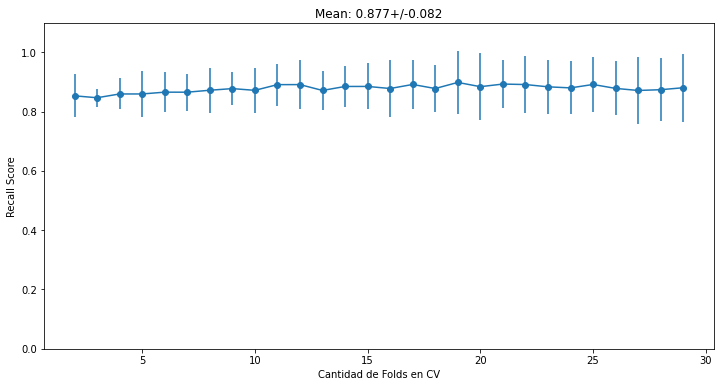

In [24]:
plt_eb(svc_model,30)

In [25]:
# hyperparam = {"C":np.logspace(-2,0,30),"gamma":np.logspace(-2,0,20)}
# svc_model = SVC(break_ties=True,probability=True)
# svc_grilla = GridSearchCV(svm_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
# svc_grilla.fit(feat_train,targ_train)
# print(svc_grilla.best_params_)
# svc_model = svc_grilla.best_estimator_

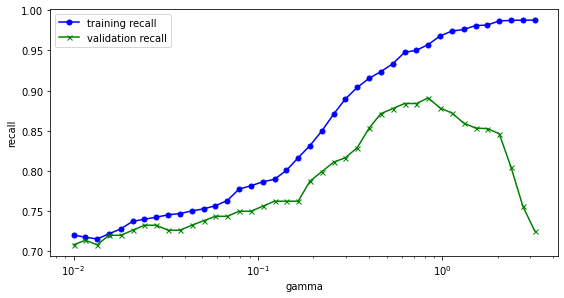

In [26]:
train_val_curve(svc_model,"gamma",np.logspace(-2,0.5,40))

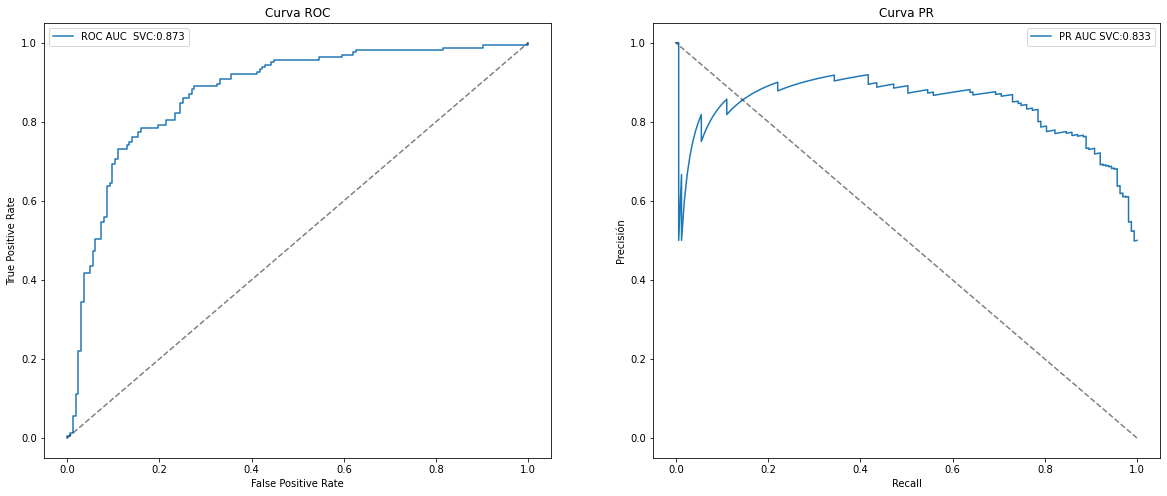

In [27]:
auc_data_svc = []
(ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(svc_model,feat_train,targ_train)
auc_data_svc.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, svc_model))
auc_curves_plot(auc_data_svc,'SVC')

---

# Random Forest

## BEST PARAMS => n_estimators = 400, min_impurity_decrease = 2e-4 -> Recall = 0.872+/-0.083

Cross Validation Score: 0.861 +/- 0.096
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       163
           1       0.80      0.87      0.83       163

    accuracy                           0.83       326
   macro avg       0.83      0.83      0.82       326
weighted avg       0.83      0.83      0.82       326



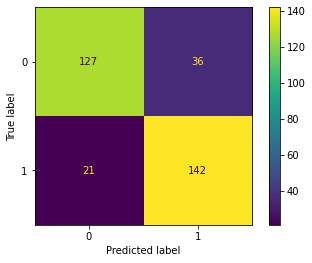

In [28]:
rf_model = RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4)
model_setup(rf_model)

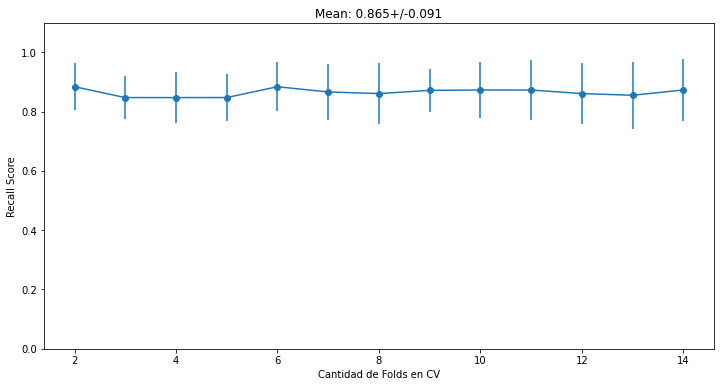

In [29]:
plt_eb(rf_model,15)

In [30]:
# hyperparam = {"n_estimators":[40],"max_depth":[6],"min_samples_split":[40]}
# rf_model = RandomForestClassifier()
# rf_grilla = GridSearchCV(rf_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
# rf_grilla.fit(feat_train,targ_train)
# rf_model = rf_grilla.best_estimator_
# print(rf_grilla.best_params_)

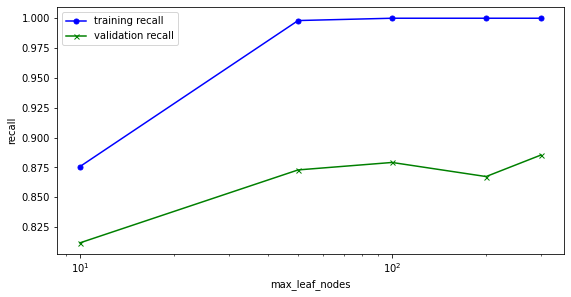

In [31]:
train_val_curve(rf_model,"max_leaf_nodes",[10,50,100,200,300])

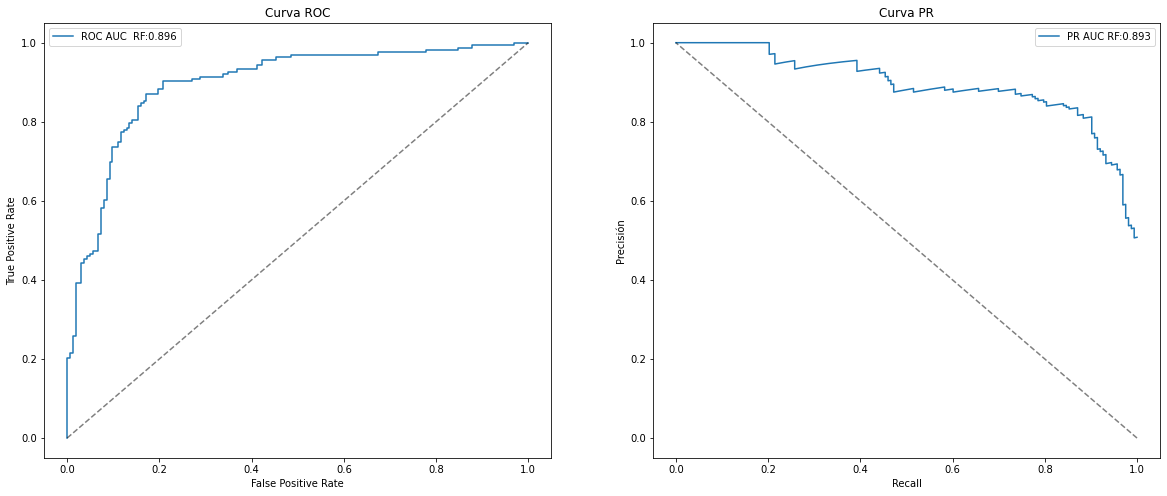

In [32]:
auc_data_rf = []
(ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(rf_model,feat_train,targ_train)
auc_data_rf.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, rf_model))
auc_curves_plot(auc_data_rf,'RF')

---

# ADA BOOSTING

Cross Validation Score: 0.792 +/- 0.086
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       163
           1       0.68      0.75      0.71       163

    accuracy                           0.70       326
   macro avg       0.70      0.70      0.70       326
weighted avg       0.70      0.70      0.70       326



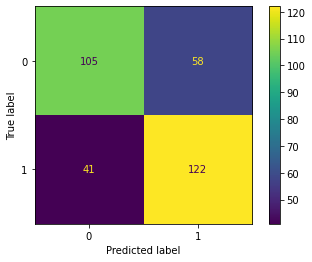

In [33]:
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate=0.2)
model_setup(ada_model)

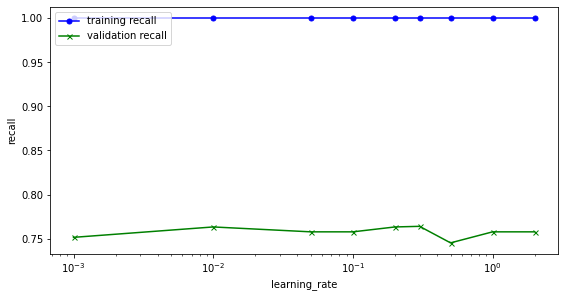

In [34]:
train_val_curve(ada_model,"learning_rate",[0.001,0.01,0.05,0.1,0.2,0.3,0.5,1,2])

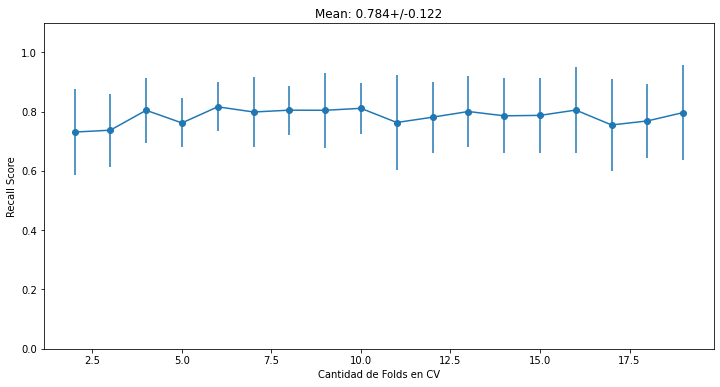

In [35]:
plt_eb(ada_model,20)

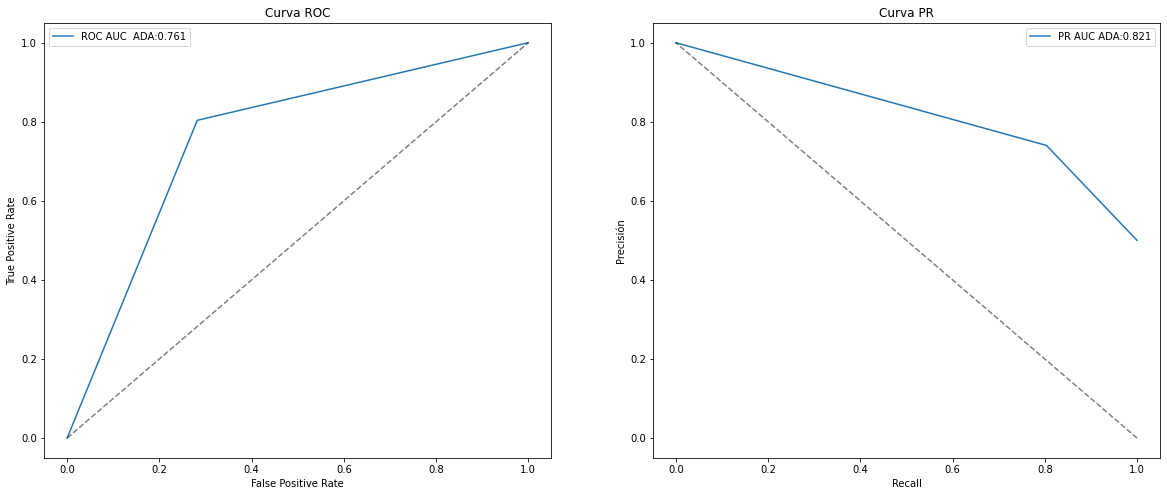

In [36]:
auc_data_ada = []
(ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(ada_model,feat_train,targ_train)
auc_data_ada.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, ada_model))
auc_curves_plot(auc_data_ada,'ADA')


---


# GRADIENT BOOSTING

## BEST PARAMS => n_estimators = 500, learning_rate = 0.05,objective="binary:hinge" -> Recall = 0.843+/-0.158

### Cambia levemente la metodologia, usa early stopping

In [37]:
feat_train_2, feat_val, targ_train_2, targ_val = train_test_split(feat_train,targ_train,random_state=420)
# NECESARIO CREAR DATOS DE VALIDACION PARA USAR XGBC

In [38]:
xgbc_model = XGBClassifier(use_label_encoder=False,objective='binary:hinge',learning_rate=0.05,n_estimators=500)
xgbc_model.fit(feat_train_2,targ_train_2,eval_set=[(feat_train_2, targ_train_2), (feat_val, targ_val)],eval_metric="error",early_stopping_rounds=20,verbose=True)
xgbc_scoring = cross_val_score(xgbc_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(xgbc_scoring.mean(),xgbc_scoring.std())) 

[0]	validation_0-error:0.52459	validation_1-error:0.42683
[1]	validation_0-error:0.52459	validation_1-error:0.42683
[2]	validation_0-error:0.52459	validation_1-error:0.42683
[3]	validation_0-error:0.52459	validation_1-error:0.42683
[4]	validation_0-error:0.52459	validation_1-error:0.42683
[5]	validation_0-error:0.52459	validation_1-error:0.42683
[6]	validation_0-error:0.52459	validation_1-error:0.42683
[7]	validation_0-error:0.52459	validation_1-error:0.42683
[8]	validation_0-error:0.52459	validation_1-error:0.42683
[9]	validation_0-error:0.52459	validation_1-error:0.42683
[10]	validation_0-error:0.52459	validation_1-error:0.42683
[11]	validation_0-error:0.18443	validation_1-error:0.29268
[12]	validation_0-error:0.15574	validation_1-error:0.29268
[13]	validation_0-error:0.11885	validation_1-error:0.26829
[14]	validation_0-error:0.10656	validation_1-error:0.28049
[15]	validation_0-error:0.10656	validation_1-error:0.26829
[16]	validation_0-error:0.10246	validation_1-error:0.26829
[17]	va

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       163
           1       0.79      0.81      0.80       163

    accuracy                           0.80       326
   macro avg       0.80      0.80      0.80       326
weighted avg       0.80      0.80      0.80       326



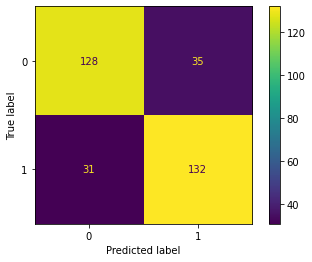

In [39]:
xgbc_predicted = cross_val_predict(xgbc_model,feat_train,targ_train,cv=10)
print(classification_report(targ_train, xgbc_predicted))
cm = confusion_matrix(targ_train, xgbc_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

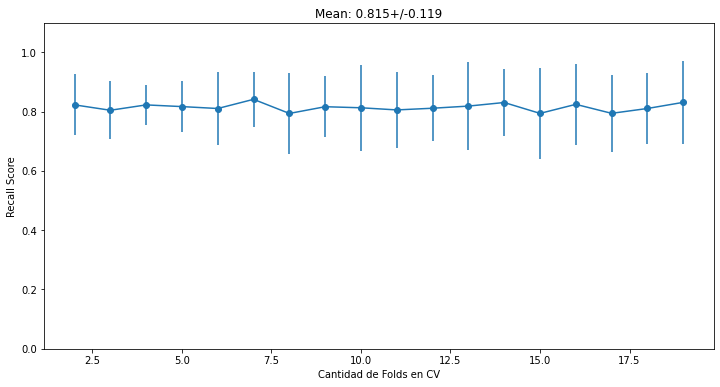

In [40]:
plt_eb(xgbc_model,20)

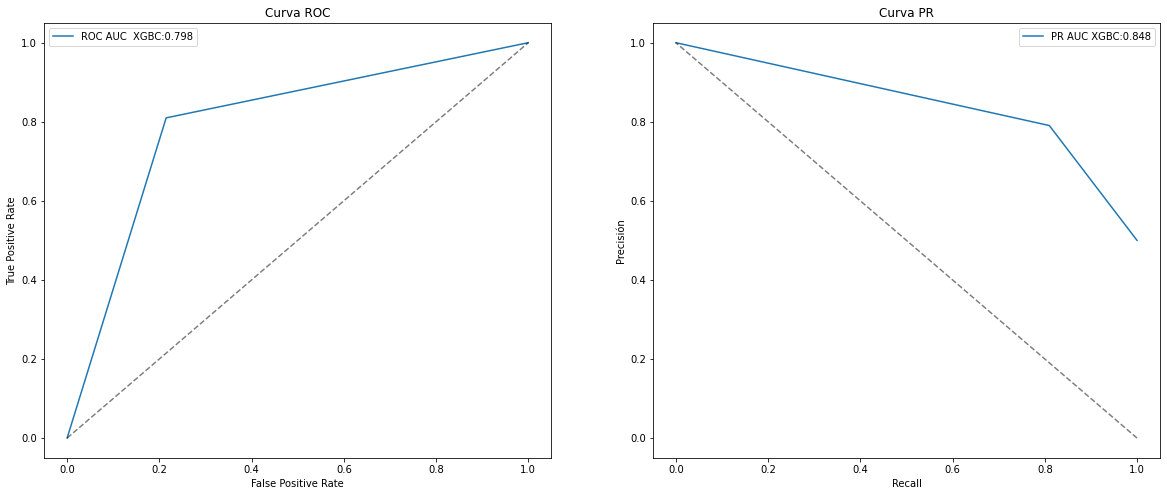

In [41]:
auc_data_xgbc = []
(ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(xgbc_model,feat_train,targ_train)
auc_data_xgbc.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, xgbc_model))
auc_curves_plot(auc_data_xgbc,'XGBC')

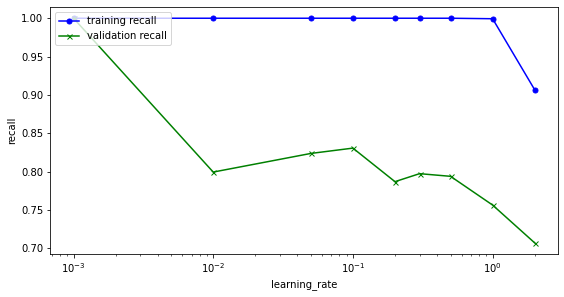

In [42]:
train_val_curve(xgbc_model,"learning_rate",[0.001,0.01,0.05,0.1,0.2,0.3,0.5,1,2])

---

# VOTING

In [44]:
vot_hard_model = VotingClassifier(
    estimators=[('lr', lr_model), ('tree', rf_model), ('svc', svc_model)],
    voting='hard')
    
vot_soft_model = VotingClassifier(
    estimators=[('lr', lr_model), ('tree', rf_model), ('svc', svc_model)],
    voting='soft')

## HARD

Cross Validation Score: 0.860 +/- 0.089
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       163
           1       0.78      0.83      0.80       163

    accuracy                           0.80       326
   macro avg       0.80      0.80      0.80       326
weighted avg       0.80      0.80      0.80       326



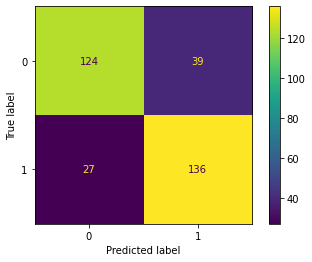

In [45]:
model_setup(vot_hard_model)

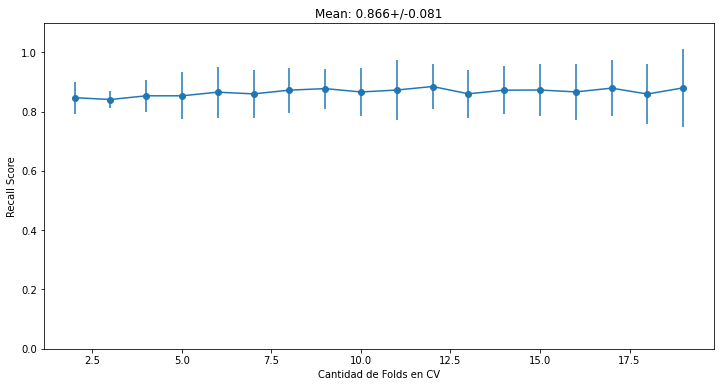

In [46]:
plt_eb(vot_hard_model,20)

## SOFT

Cross Validation Score: 0.854 +/- 0.094
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       163
           1       0.77      0.83      0.80       163

    accuracy                           0.79       326
   macro avg       0.79      0.79      0.79       326
weighted avg       0.79      0.79      0.79       326



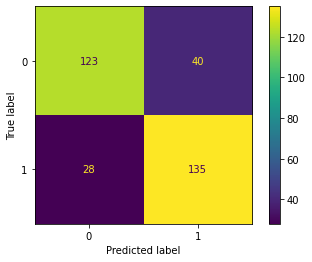

In [47]:
model_setup(vot_soft_model)

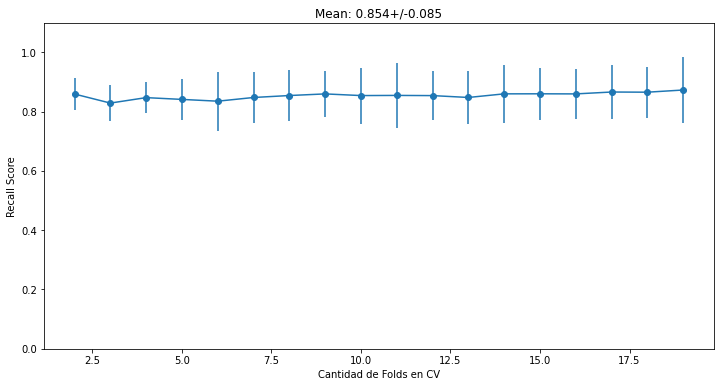

In [48]:
plt_eb(vot_soft_model,20)

---

# RED NEURONAL SIMPLE

In [49]:
keras.backend.clear_session()

In [50]:
input = keras.layers.Input(shape=[6,])
flatten = keras.layers.Flatten()(input)
hidden1 = keras.layers.Dense(100, activation="relu")(flatten)
dropout = keras.layers.Dropout(rate=0.2)(hidden1)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
output = keras.layers.Dense(1, activation="sigmoid")(hidden2)

model = keras.models.Model(inputs=[input], outputs=[output])

2021-11-15 01:01:44.528352: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-15 01:01:44.528506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 01:01:44.528802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.65GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-11-15 01:01:44.528884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 01:01:44.528937: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic librar

In [51]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.keras.metrics.Recall()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
flatten (Flatten)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 100)               700       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(feat_train, targ_train, epochs=2000, batch_size=32,
                    validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)])

2021-11-15 01:01:49.680721: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-15 01:01:49.699411: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3997855000 Hz


Epoch 1/2000
9/9 [==============================] - 1s 20ms/step - loss: 0.6635 - recall: 0.6495 - val_loss: 0.6402 - val_recall: 0.5758
Epoch 2/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.6091 - recall: 0.5773 - val_loss: 0.6650 - val_recall: 0.5000
Epoch 3/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.5717 - recall: 0.5464 - val_loss: 0.7293 - val_recall: 0.4697
Epoch 4/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.5514 - recall: 0.5155 - val_loss: 0.7689 - val_recall: 0.4697
Epoch 5/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.5351 - recall: 0.5464 - val_loss: 0.6994 - val_recall: 0.5152
Epoch 6/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.5236 - recall: 0.5773 - val_loss: 0.6862 - val_recall: 0.5606
Epoch 7/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.5149 - recall: 0.5670 - val_loss: 0.7501 - val_recall: 0.5303
Epoch 8/2000
9/9 [=============================

In [53]:
model.evaluate(feat_train,targ_train)

11/11 [==============================] - 0s 535us/step - loss: 0.0545 - recall: 0.9755


[0.054533977061510086, 0.9754601120948792]

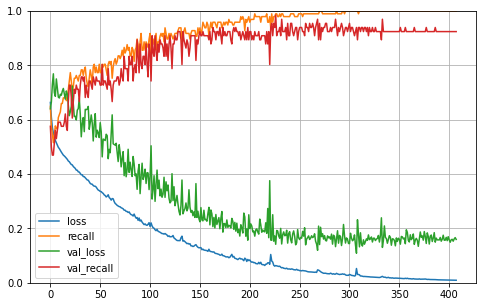

In [54]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [55]:
pd.DataFrame(history.history)

,loss,recall,val_loss,val_recall
0,0.663526,0.649485,0.640168,0.575758
1,0.609065,0.577320,0.665003,0.500000
2,0.571697,0.546392,0.729323,0.469697
3,0.551432,0.515464,0.768933,0.469697
4,0.535071,0.546392,0.699404,0.515152
...,...,...,...,...
403,0.009902,1.000000,0.159942,0.924242
404,0.009773,1.000000,0.153108,0.924242
405,0.009543,1.000000,0.161427,0.924242
406,0.009555,1.000000,0.166330,0.924242


(array([149.,   8.,   2.,   2.,   3.,   1.,   3.,   3.,   9., 146.]),
 array([3.01175689e-08, 1.00000024e-01, 2.00000018e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 8.99999976e-01, 1.00000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

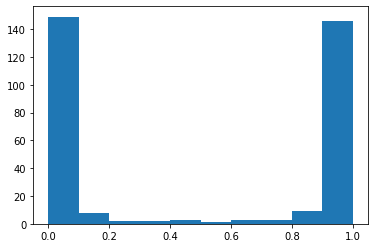

In [56]:
plt.hist(model.predict(feat_train))

(array([163.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 163.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

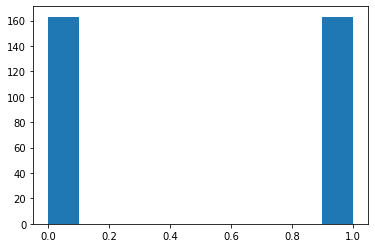

In [57]:
plt.hist(targ_train)

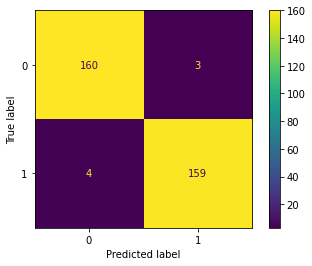

In [58]:
cm = confusion_matrix(targ_train, model.predict(feat_train)>0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [59]:
#Resumen final
AUC_data = [auc_data_percep1,auc_data_percep2,auc_data_lr,auc_data_svc,auc_data_rf,auc_data_ada, auc_data_xgbc]
auc_curves_plot(AUC_data)

TypeError: auc_curves_plot() missing 1 required positional argument: 'name_model'